# Student Loan XGBoost Project

## Madison Li, Heeth Surana. Ziqi Tang, Guo Wei

In [1]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
import xgboost as xgb
from sklearn.model_selection import KFold
import time

In [2]:
# import data and pull out features
data = pd.read_csv('student_loan.csv').drop(columns = ['load_id','deal_name'])
label = data['paid_label']
features = data.drop(columns = ['paid_label'])
features.head()

,loan_age,cosign,income_annual,upb,monthly_payment,fico,origbalance,mos_to_repay,repay_status,mos_to_balln
0,56,0,113401.60,36011.11,397.91,814,51453.60,0,0,124
1,56,1,100742.34,101683.38,1172.10,711,130271.33,0,0,124
2,56,0,46000.24,49249.37,593.57,772,62918.96,0,0,124
3,56,0,428958.96,36554.85,404.63,849,48238.73,0,0,125
4,56,0,491649.96,7022.30,1967.46,815,106124.68,0,0,4


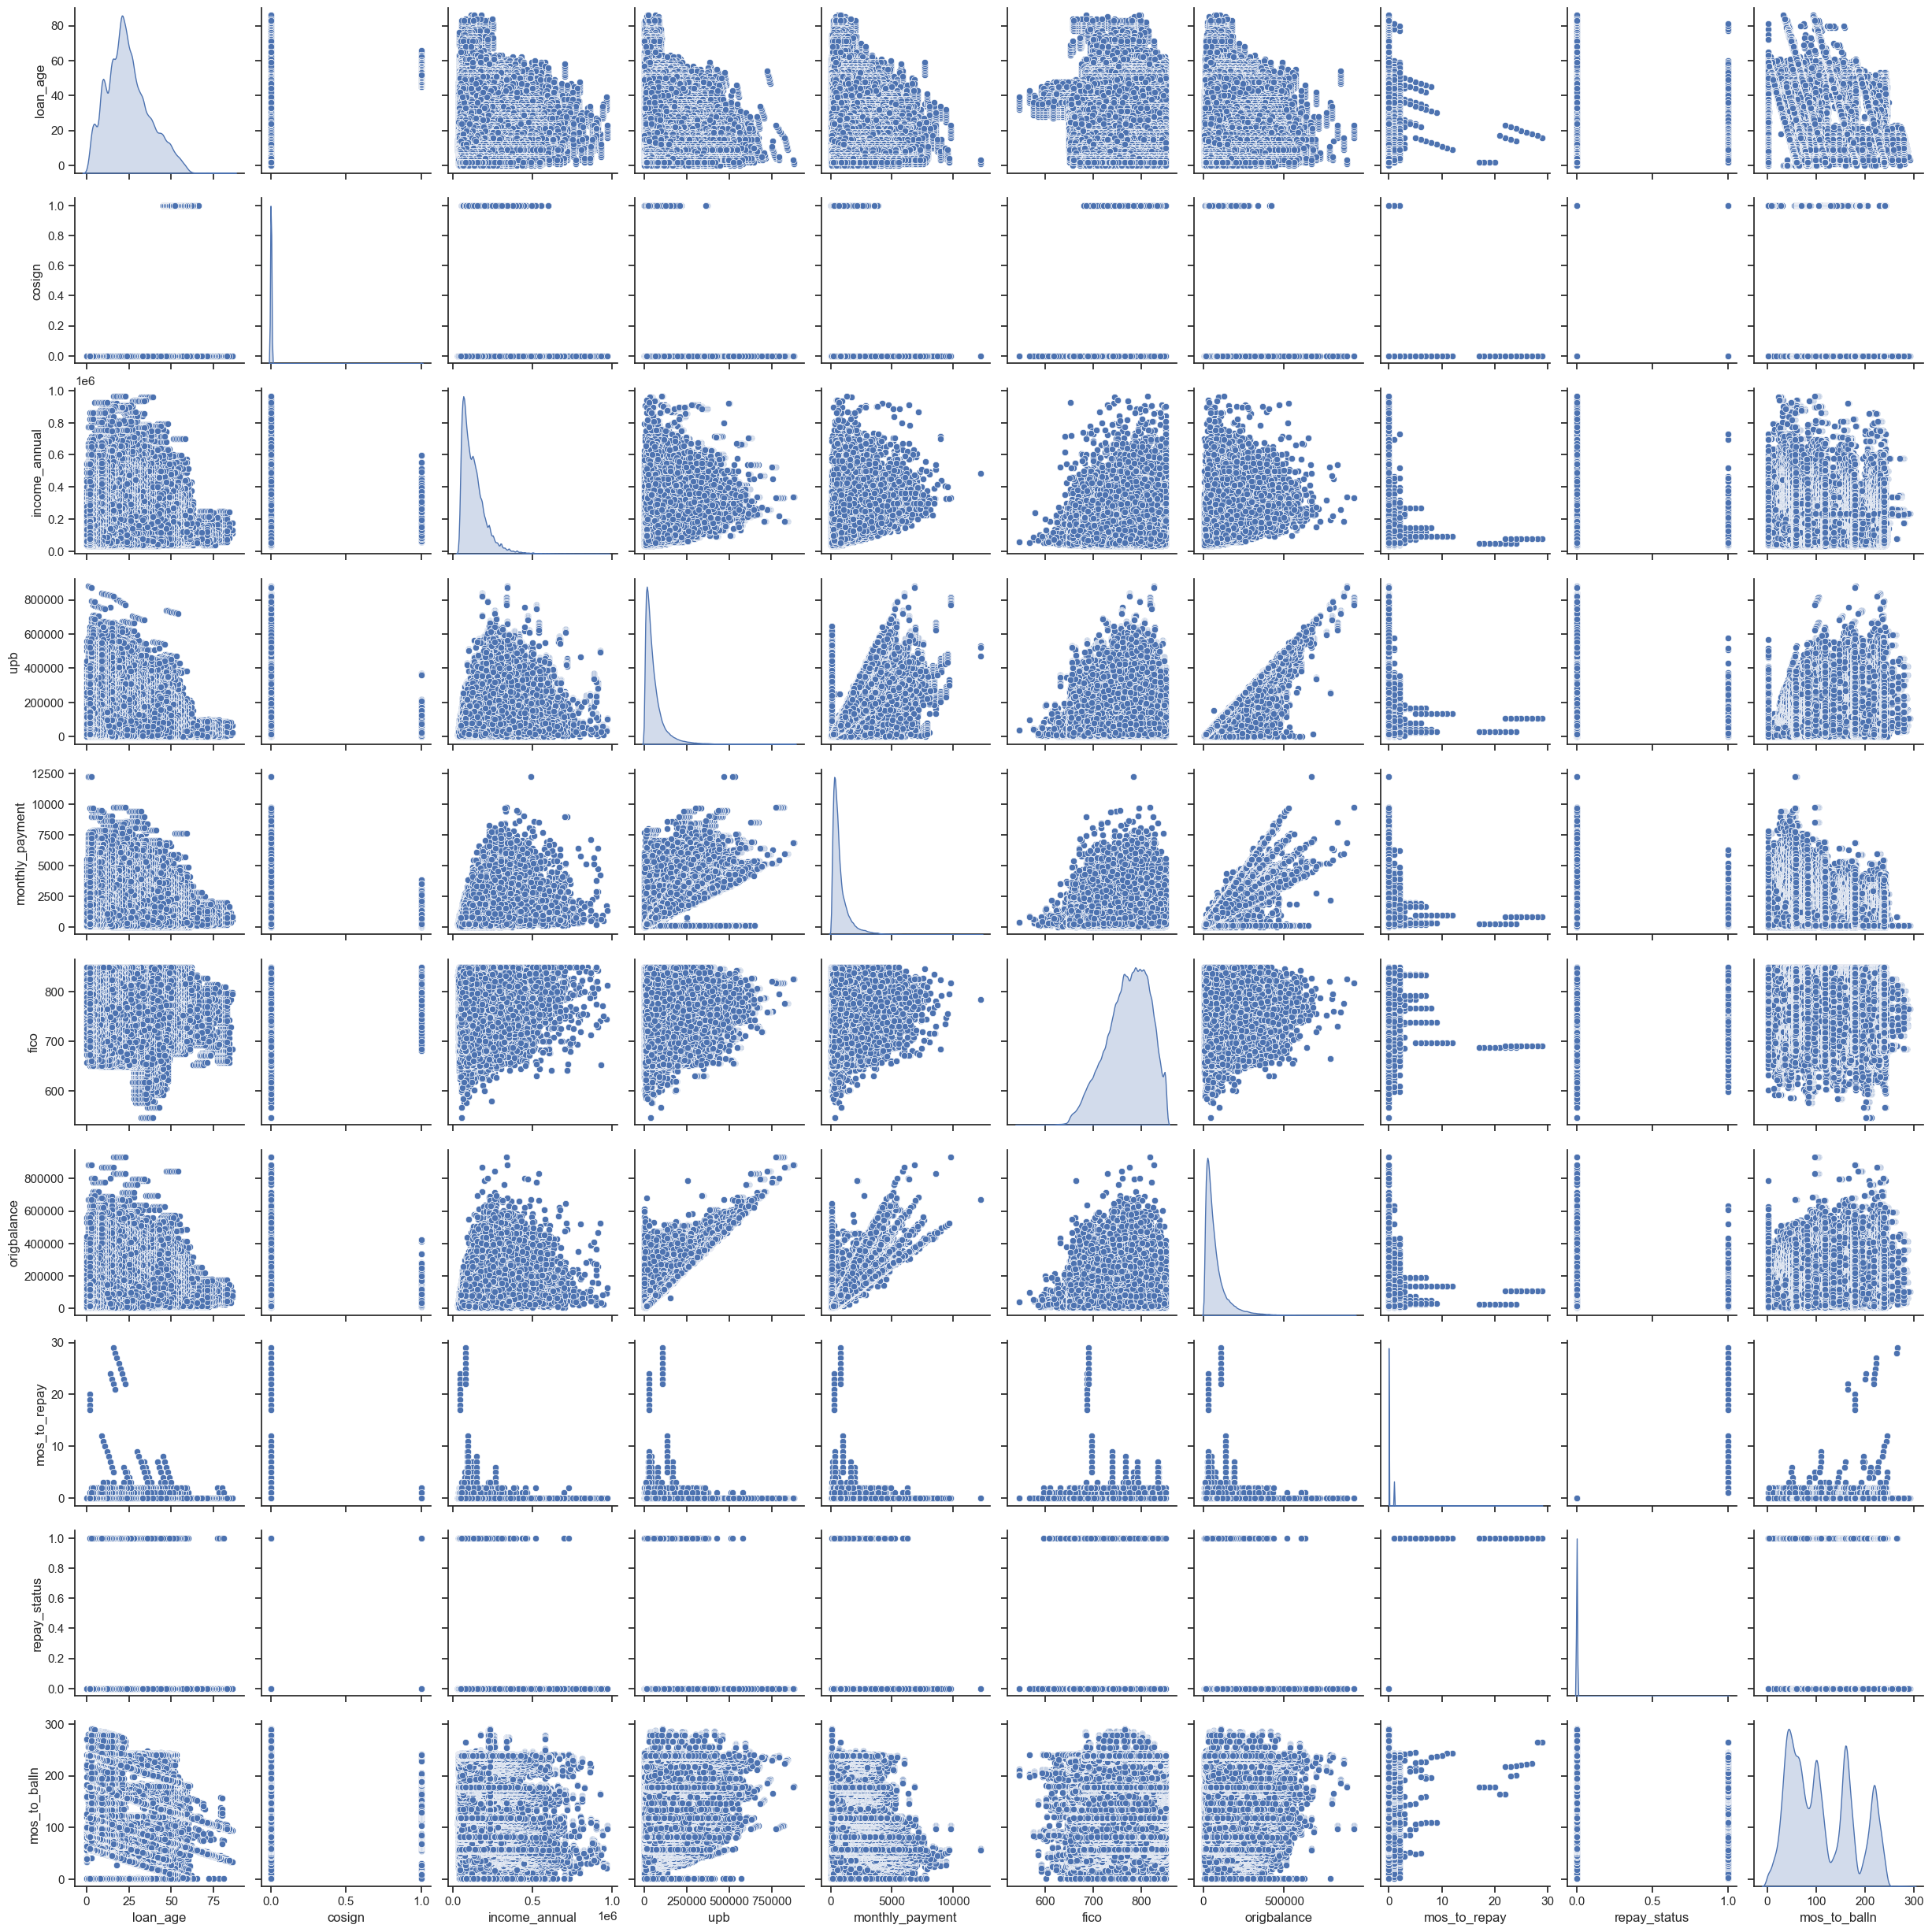

In [3]:
# Look for multicollinearity and individual asset distributions by plotting each feature against each other
sns.set(style="ticks")
sns.pairplot(features, diag_kind='kde', markers="o")
plt.show()

In [4]:
# Verify whether correlations are actually high as inferred from graphs
features.corr()

,loan_age,cosign,income_annual,upb,monthly_payment,fico,origbalance,mos_to_repay,repay_status,mos_to_balln
loan_age,1.000000,0.146169,-0.003979,-0.139888,-0.013449,-0.074826,-0.017437,0.002943,0.009108,-0.170205
cosign,0.146169,1.000000,0.028643,-0.015566,-0.009682,-0.004848,-0.003197,0.001480,0.003566,-0.006407
income_annual,-0.003979,0.028643,1.000000,0.409556,0.502676,0.182676,0.478881,-0.007178,-0.008348,-0.099692
upb,-0.139888,-0.015566,0.409556,1.000000,0.742299,-0.011930,0.945436,0.007856,0.011730,0.324893
monthly_payment,-0.013449,-0.009682,0.502676,0.742299,1.000000,0.070972,0.863744,0.001254,0.003383,-0.112549
fico,-0.074826,-0.004848,0.182676,-0.011930,0.070972,1.000000,0.019309,-0.019517,-0.025255,-0.204663
origbalance,-0.017437,-0.003197,0.478881,0.945436,0.863744,0.019309,1.000000,0.003884,0.006157,0.187899
mos_to_repay,0.002943,0.001480,-0.007178,0.007856,0.001254,-0.019517,0.003884,1.000000,0.639569,0.020417
repay_status,0.009108,0.003566,-0.008348,0.011730,0.003383,-0.025255,0.006157,0.639569,1.000000,0.026674
mos_to_balln,-0.170205,-0.006407,-0.099692,0.324893,-0.112549,-0.204663,0.187899,0.020417,0.026674,1.000000


Observations:
- Months to Repay (mos_to_repay) has almost all its distribution clustered into a few values. Seems categorical.
- Cosign and repay_status are binary categorical variables.
- Unpaid balance and original balance are highly correlated. Seems reasonable since large loans will tend to have larger unpaid balances.
- Original balance (and upb) and monthly payment are highly correlated. Makes intuitive sense since the larger the loan, the higher the monthly payment. 

The presence of multicollinearity should be noted when determining feature importance.

### Determining feature importance

Before directly jumping into classification models, some data cleanup is required. We need to determine whether categorical variables are significant.

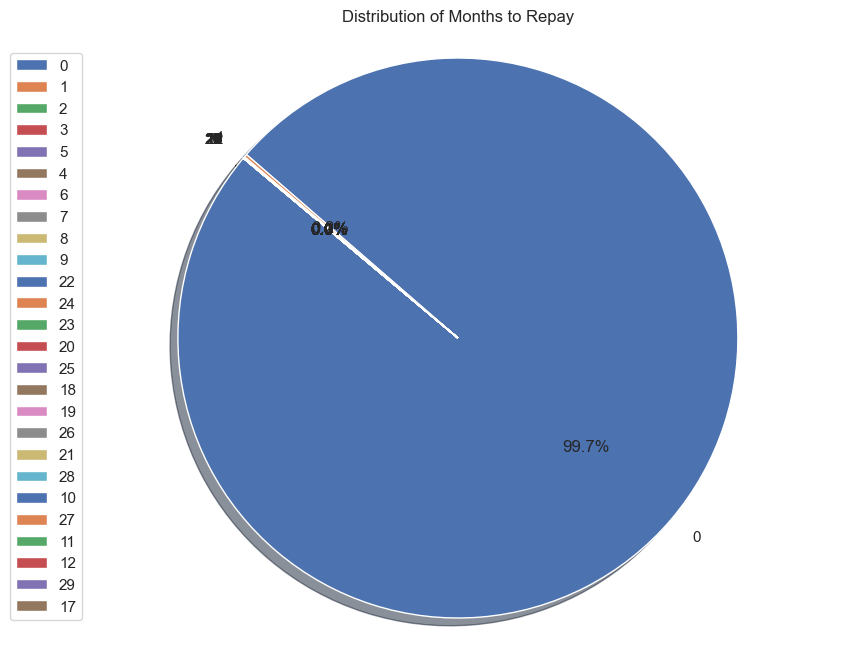

In [5]:
# Determine how distributed months to repay is
category_counts = features['mos_to_repay'].value_counts()
categories = category_counts.index
category_values = category_counts.values
plt.figure(figsize=(10, 8))  
plt.pie(category_values, labels=categories, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution of Months to Repay')
plt.legend(categories, loc='upper right', bbox_to_anchor=(0.025, 0.975))
plt.axis('equal')
plt.show()

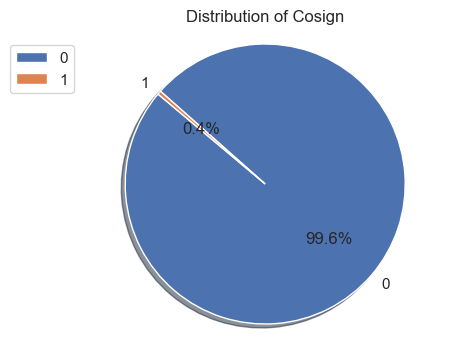

In [6]:
# Determine what % of loans have cosign
category_counts = features['cosign'].value_counts()
categories = category_counts.index
category_values = category_counts.values
plt.figure(figsize=(5, 4))  
plt.pie(category_values, labels=categories, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution of Cosign')
plt.legend(categories, loc='upper right', bbox_to_anchor=(0.025, 0.975))
plt.axis('equal')
plt.show()

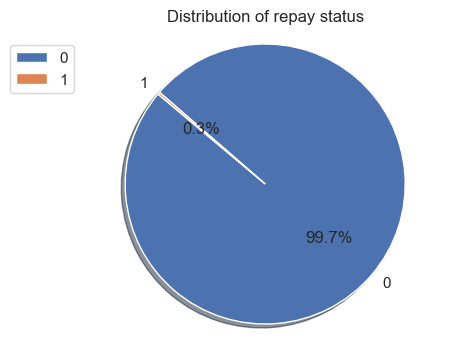

In [7]:
# Determine what % of loans have repayed_status flagged
category_counts = features['repay_status'].value_counts()
categories = category_counts.index
category_values = category_counts.values
plt.figure(figsize=(5, 4))  
plt.pie(category_values, labels=categories, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution of repay status')
plt.legend(categories, loc='upper right', bbox_to_anchor=(0.025, 0.975))
plt.axis('equal')
plt.show()

All three variables can be dropped. Almost all samples have the three as 0. There is very little heterogeneity in the three variables.

In [8]:
# Drop cosign, repay status, months to repay
features = features.drop(columns=['cosign','repay_status','mos_to_repay'])
features.head()

,loan_age,income_annual,upb,monthly_payment,fico,origbalance,mos_to_balln
0,56,113401.60,36011.11,397.91,814,51453.60,124
1,56,100742.34,101683.38,1172.10,711,130271.33,124
2,56,46000.24,49249.37,593.57,772,62918.96,124
3,56,428958.96,36554.85,404.63,849,48238.73,125
4,56,491649.96,7022.30,1967.46,815,106124.68,4


- Determine feature importance using decision trees

In [9]:
# Fit a decision tree to the data and rank features by importance
mdl_tree = DecisionTreeClassifier(random_state = 0)
mdl_tree.fit(features, label)
dct_cols = {'feature':features.columns.values, 'importance':mdl_tree.feature_importances_}
pd.DataFrame(dct_cols).sort_values('importance', ascending = False)

,feature,importance
6,mos_to_balln,0.302693
2,upb,0.247677
3,monthly_payment,0.104580
5,origbalance,0.096902
0,loan_age,0.091497
1,income_annual,0.091263
4,fico,0.065388


- Determine feature importance using Lasso

In [10]:
# Fit a Lasso to the data and determine most significant features
lasso = Lasso(alpha=0.25)
lasso.fit(features, np.ravel(label.values))
df_lasso_coefficients = \
    pd.DataFrame({
        'feature':features.columns,
        'absolute coefficient':abs(lasso.coef_)
    })
df_lasso_coefficients.sort_values('absolute coefficient', ascending = False)


,feature,absolute coefficient
6,mos_to_balln,4.484351e-05
3,monthly_payment,1.662691e-05
5,origbalance,1.002262e-06
2,upb,9.805116e-07
1,income_annual,3.481853e-08
0,loan_age,0.000000e+00
4,fico,0.000000e+00


Both Decision Trees and Lasso indicate mos_to_balln and monthly_payment as important features in predicting loan prepayment. Both upd and origbalance are highly correlated to each other as well as monthly_payment, and including them as important features would result in creating several near-proxies of the same explanatory variable. The next best feature to be considered important hence is income_annual.

### Determine directional relationship

In [11]:
# Determining directional relationship between each feature and loan prepayment using linear regression
lr_model = LinearRegression(fit_intercept=True)
df = pd.DataFrame(np.nan, index=range(len(features.columns.values)), columns=['Features', 'Coef'])
for i in range(len(features.columns.values)):
    df.iloc[i,0] = features.columns.values[i]
    # print(df_X.columns.values[i])
    dfx_i = np.array(features[features.columns.values[i]]).reshape((-1,1))
    dfy = np.array(label)
    lr_model.fit(dfx_i,dfy)
    df.iloc[i,1] = lr_model.coef_
print(df)

          Features          Coef
0         loan_age  4.502739e-04
1    income_annual  8.390478e-09
2              upb -7.040707e-08
3  monthly_payment  3.586495e-06
4             fico  3.338670e-05
5      origbalance  2.123953e-08
6     mos_to_balln -1.740783e-04


We see that for the three most important variables, on average:
- There is a negative relationship between mos_to_balln (months to balance) and loan prepayment. Assuming that mos_to_balln indicates the number of monthly payments left until unpaid loan balance is zero, this indicates that most loans tend to be prepaid nearer to the end of the loan duration.
- There is a positive relationship between monthly payment and loan repayment. The higher the monthly payment, the likelier a loan to be repaid. This is reasonable since a high monthly payment (installment + interest) makes it more prudent to settle a loan earlier despite additional costs in doing so.
- There is a positive relationship between annual income and loan prepayment. Someone with higher disposable income is likelier to have the excess funds available to service early loan repayment. 

### XGBoost Classification with Hyperparameter Tuning

- Independent hyperparameter tuning with 3-fold cross validation

We will tune max_depth, n_estimators, and learning rate.

In [12]:
# Tuning max_depth
# folds for cross validation
kf = KFold(n_splits = 3, shuffle = True, random_state = 0)

# various levels of max_depth we will try
lst_weight = [1, 2, 3, 4, 5, 10, 15, 20, 25]

# lists for storing average statistics

lst_eb_ratio_avg = []
lst_accu_avg = []
lst_prec_avg= []
lst_recall_avg = []
lst_auc_roc_avg = []

for ix_weight in lst_weight:

    # list for storing statitics for each fold of cross-validation
    lst_eb_ratio = []
    lst_accu = []
    lst_prec= []
    lst_recall = []
    lst_auc_roc = []

    for train_index, test_index in kf.split(features, label):
        # creating training set
        X_train = features.iloc[train_index]
        y_train = label.iloc[train_index]

        # creating test set
        X_test = features.iloc[test_index]
        y_test = label.iloc[test_index]

        # intantiating model
        mdl = xgb.XGBClassifier(eval_metric ='logloss', max_depth = ix_weight)


        # fit the model
        start = time.time()
        mdl.fit(X_train, y_train)
        y_pred = mdl.predict(X_test)
        end = time.time()

        # fit accuracy
        dbl_accu = accuracy_score(y_test,y_pred)
        lst_accu.append(dbl_accu)

        # precision
        dbl_prec = precision_score(y_test, y_pred, average=None)
        lst_prec.append(dbl_prec)

        # expected-balance ratio
        arr_pred_proba = mdl.predict_proba(X_test)[:,1]
        dbl_eb_ratio = (arr_pred_proba * X_test['upb']).sum() / (y_test * X_test['upb']).sum()
        lst_eb_ratio.append(dbl_eb_ratio)

        # recall
        dbl_recall = recall_score(y_test, y_pred, average=None)
        lst_recall.append(dbl_recall)

        #AUC_ROC

        dbl_auc_roc = roc_auc_score(y_test, y_pred, average=None)
        lst_auc_roc.append(dbl_auc_roc)


    # calculating and storing average metrics
    accu_avg = np.round(np.mean(lst_accu), 3)
    lst_accu_avg.append(accu_avg)

    prec_avg = np.round(np.mean(lst_prec), 3)
    lst_prec_avg.append(prec_avg)

    eb_ratio_avg = np.round(np.mean(lst_eb_ratio), 3)
    lst_eb_ratio_avg.append(eb_ratio_avg)

    recall_avg = np.round(np.mean(lst_recall),3)
    lst_recall_avg.append(recall_avg)

    auc_roc_avg = np.round(np.mean(lst_auc_roc),3)
    lst_auc_roc_avg.append(auc_roc_avg)





In [13]:
df_results = pd.DataFrame({'max_depth':lst_weight, 'Accuracy':lst_accu_avg, 'EB_ratio':lst_eb_ratio_avg, 'Precision':lst_prec_avg, 'Recall':lst_recall_avg, 'AUC_ROC':lst_auc_roc_avg})
df_results

,max_depth,Accuracy,EB_ratio,Precision,Recall,AUC_ROC
0,1,0.987,1.053,0.914,0.626,0.626
1,2,0.988,1.012,0.933,0.659,0.659
2,3,0.988,1.008,0.934,0.663,0.663
3,4,0.988,1.002,0.933,0.667,0.667
4,5,0.988,1.001,0.932,0.668,0.668
5,10,0.988,0.952,0.918,0.666,0.666
6,15,0.988,0.777,0.898,0.667,0.667
7,20,0.988,0.623,0.883,0.666,0.666
8,25,0.987,0.549,0.874,0.666,0.666


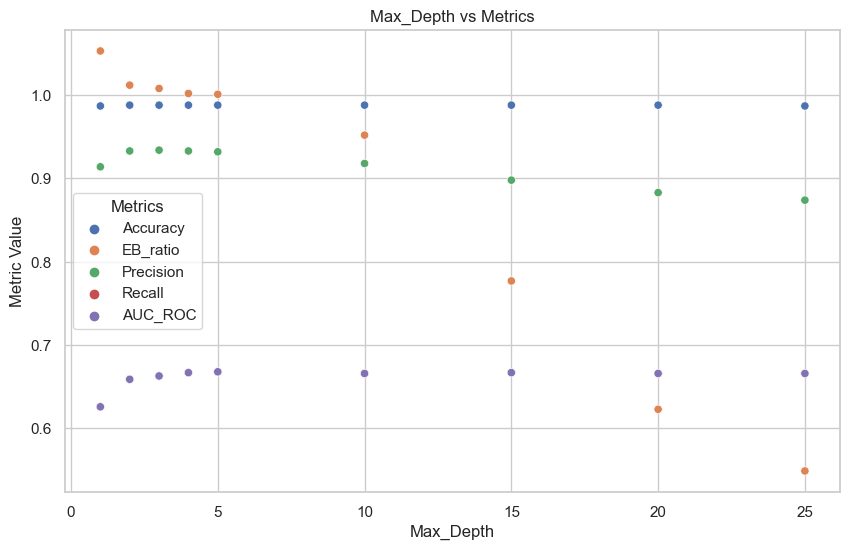

In [14]:
# Graph metrics against Max_Depth
df_long = pd.melt(df_results, id_vars=['max_depth'], value_vars=['Accuracy','EB_ratio', 'Precision', 'Recall', 'AUC_ROC'], var_name='Metric', value_name='Value')
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(x='max_depth', y='Value', hue='Metric', data=df_long, markers='o')
plt.title('Max_Depth vs Metrics')
plt.xlabel('Max_Depth')
plt.ylabel('Metric Value')
plt.legend(title='Metrics')
plt.show()

5 appears to be an obviosu optimal max_depth.

In [15]:
# Tuning n_estimators
# list for n_estimators we are going to use
lst_n = [100,200,300,500,1000,2000, 5000]

# lists for storing average statistics. Reset them to empty list for this step.
lst_eb_ratio_avg = []
lst_accu_avg = []
lst_prec_avg= []
lst_recall_avg = []
lst_auc_roc_avg = []

for ix_rate in lst_n:
    # list for storing statitics for each fold of cross-validation
    lst_eb_ratio = []
    lst_accu = []
    lst_prec= []
    lst_recall = []
    lst_auc_roc = []

    for train_index, test_index in kf.split(features, label):
        # creating training set
        X_train = features.iloc[train_index]
        y_train = label.iloc[train_index]

        # creating test set
        X_test = features.iloc[test_index]
        y_test = label.iloc[test_index]

        # intantiating model
        mdl = xgb.XGBClassifier(eval_metric ='logloss', n_estimators = ix_rate)

        # fit the model
        start = time.time()
        mdl.fit(X_train, y_train)
        end = time.time()

        # fit accuracy
        dbl_accu = accuracy_score(y_test,mdl.predict(X_test))
        lst_accu.append(dbl_accu)

        # precision
        dbl_prec = precision_score(y_test, mdl.predict(X_test), average=None)
        lst_prec.append(dbl_prec)

        # expected-balance ratio
        arr_pred_proba = mdl.predict_proba(X_test)[:,1]
        dbl_eb_ratio = (arr_pred_proba * X_test['upb']).sum() / (y_test * X_test['upb']).sum()
        lst_eb_ratio.append(dbl_eb_ratio)

        # recall
        dbl_recall = recall_score(y_test, mdl.predict(X_test), average=None)
        lst_recall.append(dbl_recall)

        #AUC_ROC
        dbl_auc_roc = roc_auc_score(y_test, mdl.predict(X_test), average=None)
        lst_auc_roc.append(dbl_auc_roc)

    # calculating and storing average metrics
    lst_accu_avg.append(np.round(np.mean(lst_accu), 3))
    lst_prec_avg.append(np.round(np.mean(lst_prec), 3))
    lst_eb_ratio_avg.append(np.round(np.mean(lst_eb_ratio), 3))
    lst_recall_avg.append(np.round(np.mean(lst_recall), 3))
    lst_auc_roc_avg.append(np.round(np.mean(lst_auc_roc), 3))

In [16]:
df_results = pd.DataFrame({'n_estimators':lst_n, 'Accuracy':lst_accu_avg, 'EB_ratio':lst_eb_ratio_avg, 'Precision':lst_prec_avg, 'Recall':lst_recall_avg, 'AUC_ROC':lst_auc_roc_avg})
df_results

,n_estimators,Accuracy,EB_ratio,Precision,Recall,AUC_ROC
0,100,0.988,1.000,0.929,0.668,0.668
1,200,0.988,0.986,0.927,0.668,0.668
2,300,0.988,0.972,0.925,0.667,0.667
3,500,0.988,0.936,0.920,0.667,0.667
4,1000,0.988,0.845,0.904,0.666,0.666
5,2000,0.988,0.694,0.879,0.665,0.665
6,5000,0.987,0.507,0.846,0.665,0.665


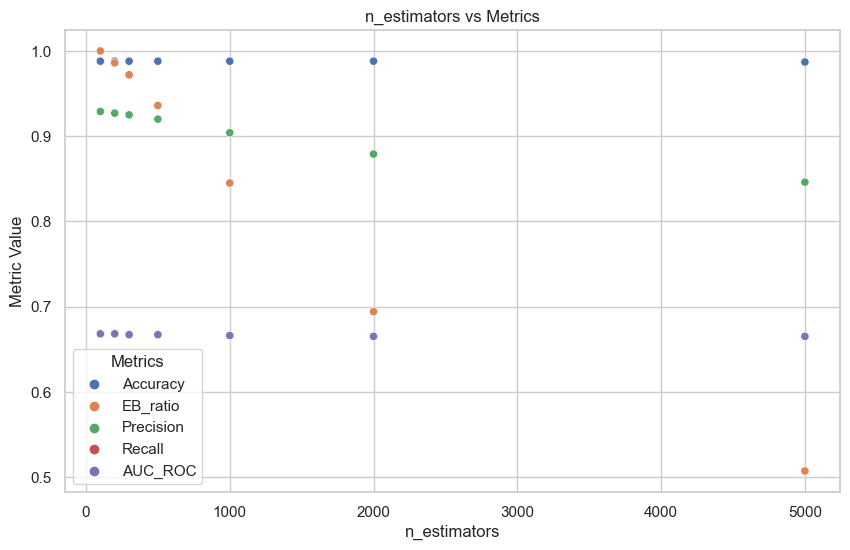

In [17]:
# Graph metrics against n_estimators
df_long = pd.melt(df_results, id_vars=['n_estimators'], value_vars=['Accuracy','EB_ratio', 'Precision', 'Recall', 'AUC_ROC'], var_name='Metric', value_name='Value')
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(x='n_estimators', y='Value', hue='Metric', data=df_long, markers='o')
plt.title('n_estimators vs Metrics')
plt.xlabel('n_estimators')
plt.ylabel('Metric Value')
plt.legend(title='Metrics')
plt.show()

Accuracy, Recall, and AUC-ROC seem to be fairly consistent across the range. Expected Balance and Precision take a relatively significant hit when n_estimators are exceeding 500. 100 to 500 seems to be an optimal range for n_estimators. 

In [18]:
# Tuning learning rates
# list for learning rates we are going to use
lst_rate = [0.0001, 0.0005, 0.001,0.005, 0.01, 0.1, 0.2] 

# lists for storing average statistics. Reset them to empty list for this step.
lst_eb_ratio_avg = []
lst_accu_avg = []
lst_prec_avg= []
lst_recall_avg = []
lst_auc_roc_avg = []

for ix_learnrate in lst_rate:
    # list for storing statitics for each fold of cross-validation
    lst_eb_ratio = []
    lst_accu = []
    lst_prec= []
    lst_recall = []
    lst_auc_roc = []

    for train_index, test_index in kf.split(features, label):
        # creating training set
        X_train = features.iloc[train_index]
        y_train = label.iloc[train_index]

        # creating test set
        X_test = features.iloc[test_index]
        y_test = label.iloc[test_index]

        # intantiating model
        mdl = xgb.XGBClassifier(eval_metric ='logloss', learning_rate = ix_learnrate)

        # fit the model
        start = time.time()
        mdl.fit(X_train, y_train)
        end = time.time()

        # fit accuracy
        dbl_accu = accuracy_score(y_test,mdl.predict(X_test))
        lst_accu.append(dbl_accu)

        # precision
        dbl_prec = precision_score(y_test, mdl.predict(X_test), average=None)
        lst_prec.append(dbl_prec)

        # expected-balance ratio
        arr_pred_proba = mdl.predict_proba(X_test)[:,1]
        dbl_eb_ratio = (arr_pred_proba * X_test['upb']).sum() / (y_test * X_test['upb']).sum()
        lst_eb_ratio.append(dbl_eb_ratio)

        # recall
        dbl_recall = recall_score(y_test, mdl.predict(X_test), average=None)
        lst_recall.append(dbl_recall)

        #AUC_ROC
        dbl_auc_roc = roc_auc_score(y_test, mdl.predict(X_test), average=None)
        lst_auc_roc.append(dbl_auc_roc)

    # calculating and storing average metrics
    lst_accu_avg.append(np.round(np.mean(lst_accu), 3))
    lst_prec_avg.append(np.round(np.mean(lst_prec), 3))
    lst_eb_ratio_avg.append(np.round(np.mean(lst_eb_ratio), 3))
    lst_recall_avg.append(np.round(np.mean(lst_recall), 3))
    lst_auc_roc_avg.append(np.round(np.mean(lst_auc_roc), 3))

c:\Users\heeth\Github\FM5252\.conda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\heeth\Github\FM5252\.conda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\heeth\Github\FM5252\.conda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\heeth\Github\FM5252\.conda\lib\site-packages\sklearn

In [19]:
df_results = pd.DataFrame({'Learning rate':lst_rate, 'Accuracy':lst_accu_avg, 'EB_ratio':lst_eb_ratio_avg, 'Precision':lst_prec_avg, 'Recall':lst_recall_avg, 'AUC_ROC':lst_auc_roc_avg})
df_results

,Learning rate,Accuracy,EB_ratio,Precision,Recall,AUC_ROC
0,0.0001,0.984,10.953,0.492,0.500,0.500
1,0.0005,0.984,10.565,0.492,0.500,0.500
2,0.0010,0.984,10.103,0.492,0.500,0.500
3,0.0050,0.984,7.123,0.492,0.500,0.500
4,0.0100,0.988,4.722,0.957,0.645,0.645
5,0.1000,0.988,1.004,0.934,0.667,0.667
6,0.2000,0.988,1.002,0.930,0.669,0.669


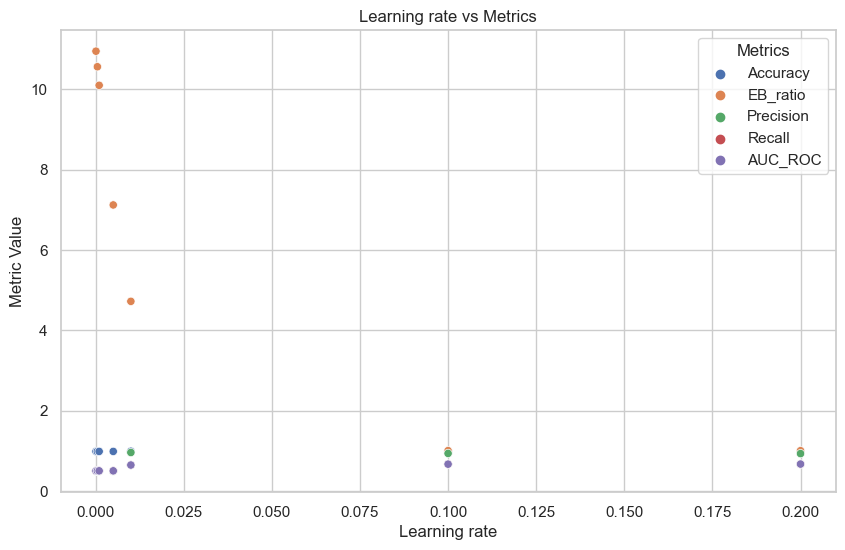

In [20]:
# Graph metrics against learning rate
df_long = pd.melt(df_results, id_vars=['Learning rate'], value_vars=['Accuracy','EB_ratio', 'Precision', 'Recall', 'AUC_ROC'], var_name='Metric', value_name='Value')
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Learning rate', y='Value', hue='Metric', data=df_long, markers='o')
plt.title('Learning rate vs Metrics')
plt.xlabel('Learning rate')
plt.ylabel('Metric Value')
plt.legend(title='Metrics')
plt.show()

Nearly all metrics show improvement as learning rate increases. The increases seem to plateau past 0.1 learning rate, so the optimal learning rate can be chosen as 0.1

- Hyperperameter tuning using GridSearchCV with 3-fold cross validation

In [21]:
xgb_classifier = xgb.XGBClassifier()


param_grid = {
    'max_depth': [1,5,10,20],
    'learning_rate': [0.1, 0.01, 0.001, 0.0001],
    'n_estimators': [100, 250, 500, 1000]
}

scoring = {'Accuracy': make_scorer(accuracy_score),'F1': make_scorer(f1_score),'ROC-AUC': make_scorer(roc_auc_score)}

grid_search = GridSearchCV(
    estimator=xgb_classifier,
    param_grid=param_grid,
    scoring=scoring,
    refit='F1',  
    cv=3)

grid_search.fit(features, label)

grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 250}

Grid Search CV indicates the best selected parameters should be 
- learning rate: 0.1
- max_depth = 5
- n_estimators = 250

Based on scoring using accuracy, F1 score, and ROC-AUC.

Results are consistent with optimal parameters found via independent tuning. 

- 5-fold Cross Validation with GridSearch CV parameters

In [22]:
# 5 folds for cross validation
kf = KFold(n_splits = 5, shuffle = True, random_state = 0)

# list for storing statitics for each fold of cross-validation
eb_ratio_sum = 0
auc_roc_sum = 0

for train_index, test_index in kf.split(features, label):
    # creating training set
    X_train = features.iloc[train_index]
    y_train = label.iloc[train_index]

    # creating test set
    X_test = features.iloc[test_index]
    y_test = label.iloc[test_index]

    # intantiating model
    mdl = xgb.XGBClassifier(eval_metric ='logloss', max_depth = 5, n_estimators = 250, learning_rate = 0.1)

    # fit the model
    start = time.time()
    mdl.fit(X_train, y_train)
    end = time.time()

    # expected-balance ratio
    arr_pred_proba = mdl.predict_proba(X_test)[:,1]
    dbl_eb_ratio = (arr_pred_proba * X_test['upb']).sum() / (y_test * X_test['upb']).sum()
    eb_ratio_sum = eb_ratio_sum + dbl_eb_ratio

    #AUC_ROC
    dbl_auc_roc = roc_auc_score(y_test, mdl.predict(X_test), average=None)
    auc_roc_sum = auc_roc_sum + dbl_auc_roc

print('Expected balance: ',eb_ratio_sum/5)
print('AUC-ROC; ',auc_roc_sum/5)



Expected balance:  1.0040100309634168
AUC-ROC;  0.6688736386414413


5-fold cross validation confirms the chosen hyperparameters provide optimal fit. From the independent tuning results, we know AUC-ROC peaks at 0.668 which is the case here too. Expected balance ratio is very close to 1 which is ideal.